In [10]:
import numpy as np
import pandas as pd
import math
import re
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.special as sp
import time

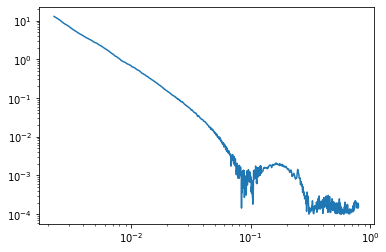

In [11]:
file_name="sample756.dat"
df = pd.read_table(file_name,header = None, sep = '\s+',names= ['q','Intensity','sigma'])

def filter_data(df, qi, qf, I_min):
    df_q = df[(df['q'] >= qi) & (df['q'] <= qf)]
    df_I = df_q[(df_q['Intensity'] >= I_min)]
    df_filtered = df_I.reset_index()
    return df_filtered

df_1 = filter_data(df,0.001,0.8,10e-5)
plt.loglog(df_1[df_1.columns[1]],df_1[df_1.columns[2]])

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [12]:
class Scatterer:
    # constructor sets q range upon initialization
    def __init__(self, q_range):
        self.q_range = q_range
        self.theta_range = np.arange(0.001,math.pi,math.pi/100)
        self.phi_range = np.arange(0.001,2*math.pi,2*math.pi/200)
        # null parameter vector for superclass Scatterer
        self.parameter_dict = None
        
    # Spherical coordinates for q space
    def qx(self,q,theta,phi):
        return q*np.sin(theta)*np.cos(phi)
    def qy(self,q,theta,phi):
        return q*np.sin(theta)*np.sin(phi)
    def qz(self,q,theta):
        return q*np.cos(theta)
    
    # return 0 form factor for general Scatterer
    def form_factor(self,q,theta,phi):
        return 0
    def simulate(self):
        print("Beginning simulation: " + re.split("\.|'",str(type(self)))[2])
        intensity = [] #final intensity
        # numerical orientation averaging for each q value
        print('Performing numerical orientational averaging.')
        startTime = time.time()
        for q_i in self.q_range:
            int_phi = [] #phi integrand
            for phi_i in self.phi_range:
                int_theta = [] #theta integrand
                for th_i in self.theta_range:
                    int_theta.append((abs(self.form_factor(q_i,th_i,phi_i))**2))
                int_phi.append(np.sin(th_i)*integrate.trapz(int_theta,self.theta_range))
            intensity.append(integrate.trapz(int_phi,self.phi_range))
        endTime = time.time()
        print("Completed Simulation.")
        print("Time for simulation: "+str(endTime-startTime) + " seconds.")
        return intensity    

In [14]:
class Bilayer(Scatterer):
    # For this object, parameters (aka kwargs) are l_tail, l_head, width,length, rho_h, rho_t, rho_water
    def __init__(self,q_range,**kwargs):
        Scatterer.__init__(self,q_range)
        self.parameter_dict = kwargs
    def set_parameter_dict(self,l_tail, l_head, width,length, rho_h, rho_t, rho_water):
        self.parameter_dict = {'Tail Length':l_tail, 'Headgroup Length':l_head,'Bilayer Height':2*l_head+l_tail,\
                               'Width':width,'Length':length,'Headgroup Electron Density':rho_h,\
                               'Tails Electron Density':rho_t, 'Water Electron Density':rho_water} 
    def form_factor(self,q,theta,phi):
        w = self.parameter_dict['Width']
        L = self.parameter_dict['Length']
        D = self.parameter_dict['Bilayer Height']
        l_tails = self.parameter_dict['Tail Length']
        rho_h = self.parameter_dict['Headgroup Electron Density']
        rho_t = self.parameter_dict['Tails Electron Density']
        rho_water = self.parameter_dict['Water Electron Density']
        return ((rho_h - rho_water)*((2*np.sin(self.qx(q,theta,phi)*w/2)/self.qx(q,theta,phi))*(2*np.sin(self.qy(q,theta,phi)*L/2)/self.qy(q,theta,phi))*(2*np.sin(self.qz(q,theta)*D/2)/self.qz(q,theta))) \
        + (rho_t - rho_h)*((2*np.sin(self.qx(q,theta,phi)*w/2)/self.qx(q,theta,phi))*(2*np.sin(self.qy(q,theta,phi)*L/2)/self.qy(q,theta,phi))*(2*np.sin(self.qz(q,theta)*l_tails/2)/self.qz(q,theta))))

    
class Nanotube(Scatterer):
    # For this object, parameters (aka kwargs) are l_tail, l_head, width,length, rho_h, rho_t, rho_water
    def __init__(self,q_range,**kwargs):
        Scatterer.__init__(self,q_range)
        self.parameter_dict = kwargs
    def set_parameter_dict(self,R_in, l_tail, l_head,length, rho_h, rho_t, rho_water):
        self.parameter_dict = {'Inner Radius':R_in,'Tail Length':l_tail,'Headgroup Length':l_head,\
                               'Bilayer Height':2*l_head+l_tail,'Tube Length':length,\
                               'Headgroup Electron Density':rho_h,'Tails Electron Density':rho_t, \
                               'Water Electron Density':rho_water} 
    #oscillating component of form factor (defined in terms of array indices for costh and q)
    def osc_L(self, q, theta,L):
        return 2 * np.sin(q * L/2 * np.cos(theta)/(q * L/2 * np.cos(theta)))
    def form_factor(self,q,theta,phi):
        R_inner = self.parameter_dict['Inner Radius']
        L = self.parameter_dict['Tube Length']
        l_head = self.parameter_dict['Headgroup Length']
        l_tails = self.parameter_dict['Tail Length']
        D = self.parameter_dict['Bilayer Height']
        rho_h = self.parameter_dict['Headgroup Electron Density']
        rho_t = self.parameter_dict['Tails Electron Density']
        rho_water = self.parameter_dict['Water Electron Density']
        R0 = R_inner
        R1 = R0 + l_head
        R2 = R1 + l_tails
        R3 = R0 + D
        V0 = np.pi * L * np.square(R0) 
        V1 = np.pi *L * np.square(R1)
        V2 = np.pi * L * np.square(R2)
        V3 = np.pi * L * np.square(R3)
        del_rho_h = rho_h - rho_water 
        del_rho_t = rho_t - rho_water
        def form_cyl(V, R):
            return V*self.osc_L(q, theta,phi) * sp.jv(1,q*np.sqrt(1 - np.cos(theta)**2)*R)/(q*np.sqrt(1 - np.cos(theta)**2)*R)
        form_0 = form_cyl(V0,R0)
        form_1= form_cyl(V1,R1)
        form_2 = form_cyl(V2,R2)
        form_3 = form_cyl(V3,R3)
        form_tube = (del_rho_h - del_rho_t) * (form_1 - form_2) + (del_rho_h) * (form_3 - form_0)                            
        return form_tube;

In [370]:
test = Scatterer(np.arange(0,1.0,0.01))

{'Tail Length': 2.0, 'Headgroup Length': 0.9, 'Bilayer Height': 3.8, 'Width': 200, 'Length': 300, 'Headgroup Electron Density': 400, 'Tails Electron Density': 300, 'Water Electron Density': 334}
Beginning simulation: Bilayer
Performing numerical orientational averaging.
Completed Simulation.
Time for simulation: 18.63556170463562 seconds.


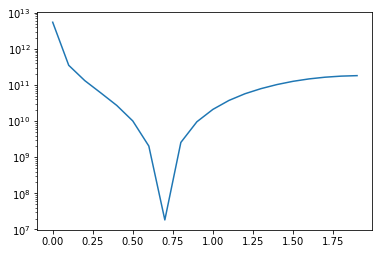

In [374]:
test2 = Bilayer(np.arange(0.001,2,0.1))
test2.set_parameter_dict(2.0,0.9,200,300,400,300,334)
print(test2.parameter_dict)
intensity2 = test2.simulate()
plt.yscale('log')
plt.plot(test2.q_range,intensity2)

{'Inner Radius': 60, 'Tail Length': 2.0, 'Headgroup Length': 0.9, 'Bilayer Height': 3.8, 'Tube Length': 500, 'Headgroup Electron Density': 400, 'Tails Electron Density': 300, 'Water Electron Density': 334}
Beginning simulation: Nanotube
Performing numerical orientational averaging.
Completed Simulation.
Time for simulation: 34.96459603309631 seconds.


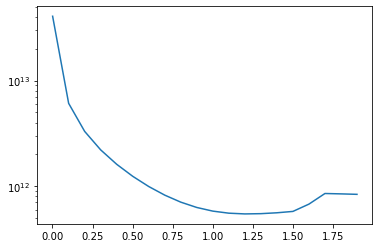

In [375]:
test3=Nanotube(np.arange(0.001,2,0.1))
test3.set_parameter_dict(60,2.0,0.9,500,400,300,334)
print(test3.parameter_dict)
intensity3=test3.simulate()
plt.yscale('log')
plt.plot(test3.q_range,intensity3)

In [15]:
# import pandas as pd
# import math
# import re
# import matplotlib.pyplot as plt
# import scipy.integrate as integrate
# import scipy.special as sp
# import time
# import numpy as np
# %load_ext cython

In [16]:
# %%cython
# cdef class Scatterer:
#     # constructor sets q range upon initialization
#     cdef object q_range
#     cdef np.float64_t[:] theta_range
#     cdef np.float64_t[:] phi_range
    
#     def __init__(self, q_range):
#         self.q_range = q_range
#         self.theta_range = np.arange(0.001,math.pi,math.pi/100)
#         self.phi_range = np.arange(0.001,2*math.pi,2*math.pi/200)
#         # null parameter vector for superclass Scatterer
#         self.parameter_dict = None
        
#     # Spherical coordinates for q space
#     def qx(self,q,theta,phi):
#         return q*np.sin(theta)*np.cos(phi)
#     def qy(self,q,theta,phi):
#         return q*np.sin(theta)*np.sin(phi)
#     def qz(self,q,theta):
#         return q*np.cos(theta)
    
#     # return 0 form factor for general Scatterer
#     def form_factor(self,q,theta,phi):
#         return 0
#     def simulate(self):
#         print("Beginning simulation: " + re.split("\.|'",str(type(self)))[2])
#         intensity = [] #final intensity
#         # numerical orientation averaging for each q value
#         print('Performing numerical orientational averaging.')
#         startTime = time.time()
#         for q_i in self.q_range:
#             int_phi = [] #phi integrand
#             for phi_i in self.phi_range:
#                 int_theta = [] #theta integrand
#                 for th_i in self.theta_range:
#                     int_theta.append((abs(self.form_factor(q_i,th_i,phi_i))**2))
#                 int_phi.append(np.sin(th_i)*integrate.trapz(int_theta,self.theta_range))
#             intensity.append(integrate.trapz(int_phi,self.phi_range))
#         endTime = time.time()
#         print("Completed Simulation.")
#         print("Time for simulation: "+str(endTime-startTime) + " seconds.")
#         return intensity
#     cpdef double c_intensity(self,double q):
#         cdef int i;
#         cdef int j;
#         cdef double intensity;
#         int_phi = []
#         for i in range(0,len(self.phi_range)):
#             int_theta = []
#             for j in range(0,len(self.theta_range)):
#                 int_theta.append((abs(self.form_factor(q,self.theta_range[j],self.phi_range[i]))**2))
#             int_phi.append(np.sin(th_i)*integrate.trapz(int_theta,self.theta_range))
#         intensity = integrate.trapz(int_phi,self.phi_range)    
#         return intensity
         

In [17]:
size = 400
iterations = 100

In [18]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [19]:
%%cython -a
import numpy as np

def mandelbrot_cython(m, size, iterations):
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if np.abs(z) <= 10:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [22]:
%%cython -a
import numpy as np

def mandelbrot_cython(int[:,::1] m,
                      int size,
                      int iterations):
    cdef int i, j, n
    cdef complex z, c
    for i in range(size):
        for j in range(size):
            c = -2 + 3./size*j + 1j*(1.5-3./size*i)
            z = 0
            for n in range(iterations):
                if z.real**2 + z.imag**2 <= 100:
                    z = z*z + c
                    m[i, j] = n
                else:
                    break

In [49]:
%%cython -a
import numpy as np
import scipy.integrate as integrate
import time

qs = np.arange(0,1,0.01)
ths = np.arange(0,np.pi,np.pi/100)
phis = np.arange(0,2*np.pi,2*np.pi/200)

cdef int m = len(qs)
cdef int o = len(ths)
cdef int p = len(phis)

def test_form(q,th,phi):
    return q*th + phi;

def simulate():
    cdef int i, j, k
    intensity = [] #final intensity
    # numerical orientation averaging for each q value
    print('Performing numerical orientational averaging.')
    startTime = time.time()
    for i in range(m):
        int_theta = [] #phi integrand
        for j in range(o):
            int_phi = [] #theta integrand
            for k in range(p):
                int_theta.append((abs(test_form(qs[i],ths[k],phis[j]))**2))
            int_phi.append(np.sin(ths[j])*integrate.trapz(int_theta,ths))
        intensity.append(integrate.trapz(int_phi,phis))
    endTime = time.time()
    print("Completed Simulation.")
    print("Time for simulation: "+str(endTime-startTime) + " seconds.")
    return intensity


# for q_i in self.q_range:
#             int_phi = [] #phi integrand
#             for phi_i in self.phi_range:
#                 int_theta = [] #theta integrand
#                 for th_i in self.theta_range:
#                     int_theta.append((abs(self.form_factor(q_i,th_i,phi_i))**2))
#                 int_phi.append(np.sin(th_i)*integrate.trapz(int_theta,self.theta_range))
#             intensity.append(integrate.trapz(int_phi,self.phi_range))

In [50]:
simulate()

Performing numerical orientational averaging.


IndexError: index 100 is out of bounds for axis 0 with size 100